In [17]:
import sys
import os
import numpy as np
import cv2
import dlib
import features
import itertools as it
import more_itertools as mit

from skimage import io
from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from matplotlib import pyplot as plt

In [6]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def plotFeature(feature):
    print feature
    return lambda tup: plt.figure() and plt.imshow(feature.show(tup[0], tup[1]))

In [8]:
images = map(io.imread, [
    "../training_data/company-day-oct-23/p6/back_center/frame_64_top_left_natural.jpg",
    "../training_data/self/p2/frame_521_top_left_straight.jpg",
    "../training_data/self/p2/frame_466_bot_right_natural.jpg",
    "../training_data/company-day-oct-23/p4/middle_center/frame_133_top_left_natural.jpg",
    "../training_data/company-day-oct-23/p7/middle_left/frame_87_top_right_natural.jpg",
    "../training_data/company-day-oct-23/p1/front_center/frame_108_top_left_natural.jpg",
    "../training_data/company-day-oct-23/p6/front_center/frame_131_top_left_natural.jpg",
    "../training_data/company-day-oct-23/p8/front_right/frame_117_top_left_natural.jpg",
    "../training_data/company-day-oct-23/p8/back_left/frame_94_top_right_natural.jpg"
])
face_detections = map(features.FaceDetection.calculate, images)

<class 'features.face_detection.FaceDetection'>


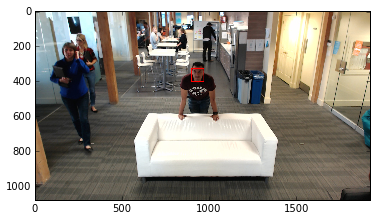

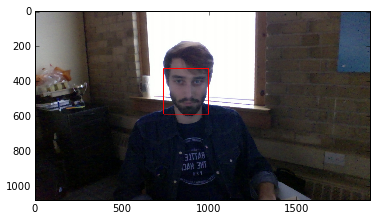

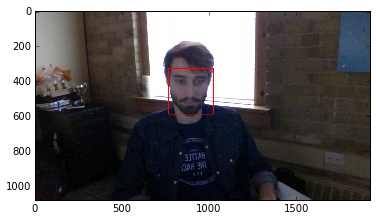

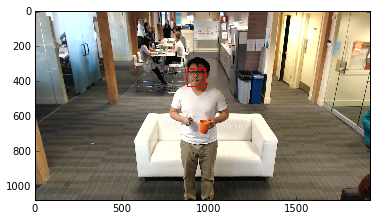

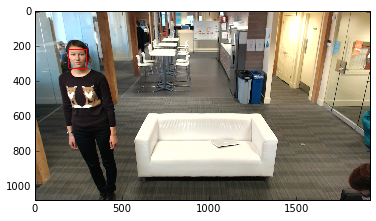

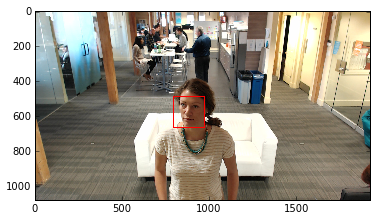

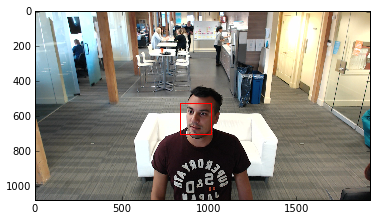

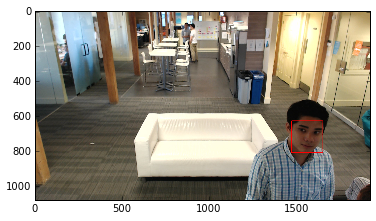

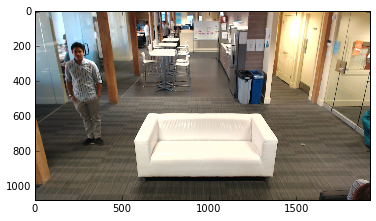

In [9]:
img_det_pairs = zip(images, face_detections)
map(plotFeature(features.FaceDetection), zip(images, face_detections))

<class 'features.face_landmarks.FaceLandmarks'>


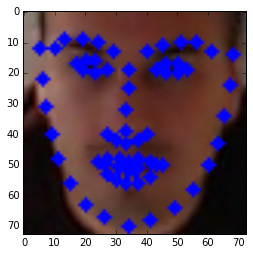

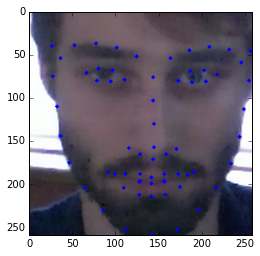

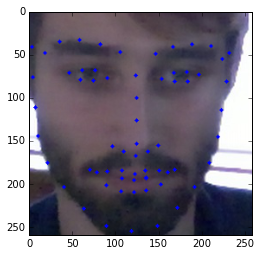

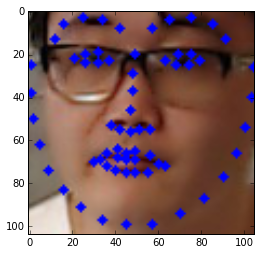

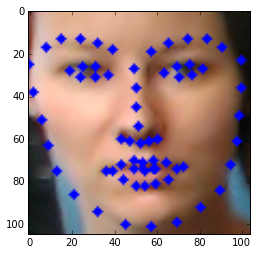

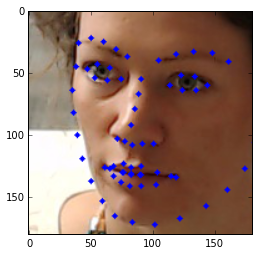

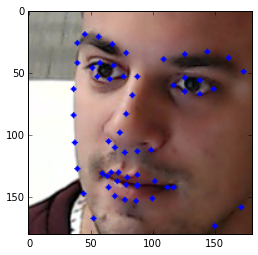

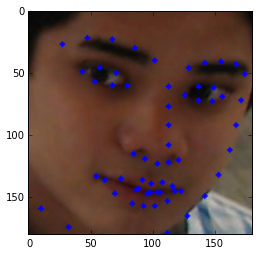

In [10]:
# [(img1, (det1, det2,...)),(img2, (det1, det2, ...))]
# -> [(img1, det1),(img1, det2),...,(img2, det1),(img2, det2)]
img_det_flat_pairs = list(mit.flatten([(x[0],y) for y in x[1]] for x in img_det_pairs))
face_keypoints = list(it.starmap(features.FaceLandmarks.calculate, img_det_flat_pairs))
map(plotFeature(f s), zip(images, face_keypoints))

<class 'features.eye_regions.EyeRegions'>


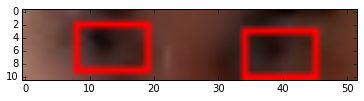

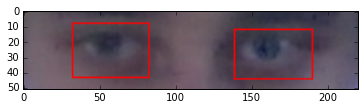

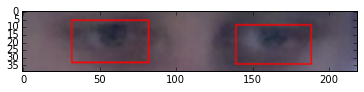

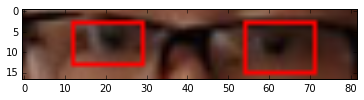

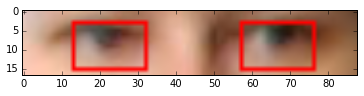

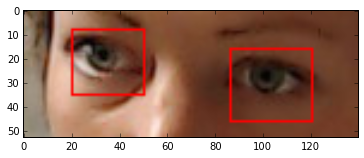

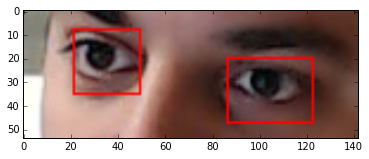

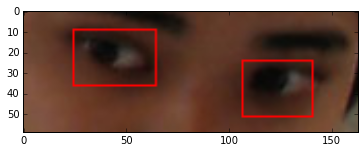

In [11]:
eye_rois = map(features.EyeRegions.calculate, face_keypoints)
map(plotFeature(features.EyeRegions), zip(images, eye_rois))

<class 'features.iris_finder.IrisFinder'>


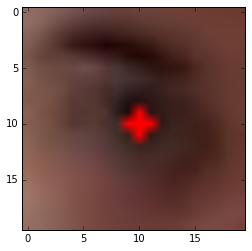

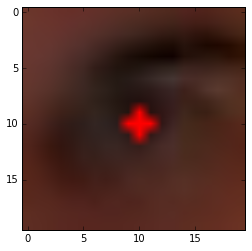

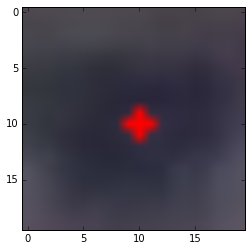

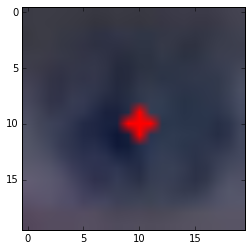

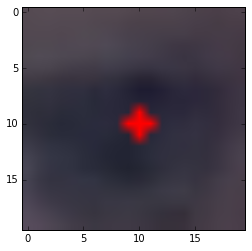

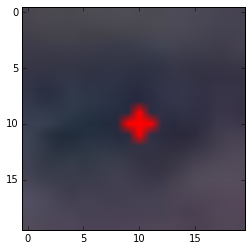

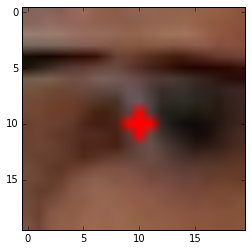

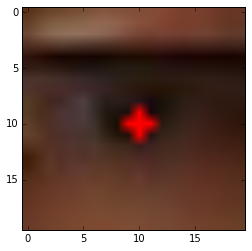

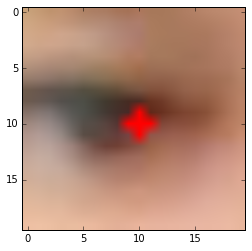

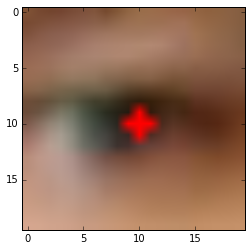

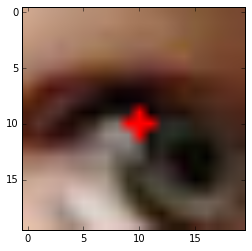

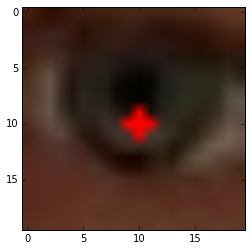

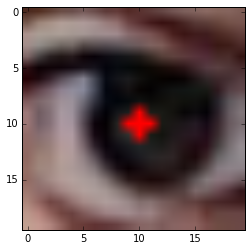

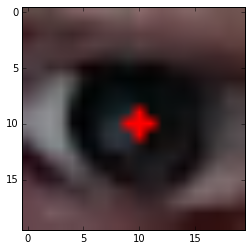

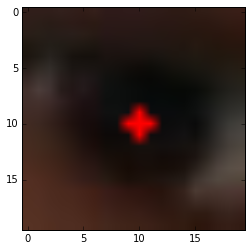

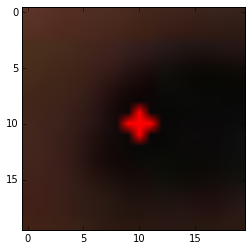

In [12]:
img_region = zip(images, eye_rois)
split_img_region = map(lambda ie: ((ie[0], ie[1].left),(ie[0],ie[1].right)),img_region)
flatmap_img_region = [val for sublist in split_img_region for val in sublist]

pupils = list(it.starmap(features.IrisFinder.calculate, flatmap_img_region))
map(plotFeature(features.IrisFinder), zip(map(lambda x: x[0], flatmap_img_region), pupils))

<class 'features.eye_ellipses.EyeEllipses'>


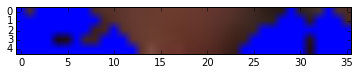

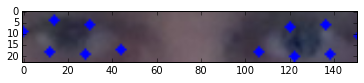

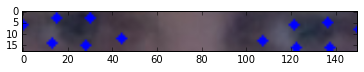

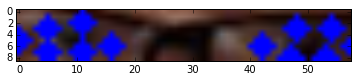

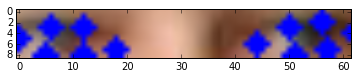

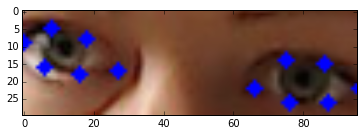

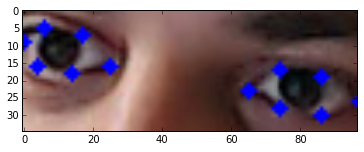

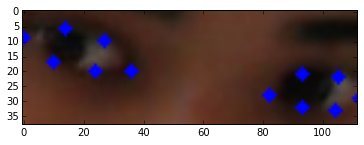

In [13]:
ellipses = map(features.EyeEllipses.calculate, face_keypoints)
map(plotFeature(features.EyeEllipses), zip(images, ellipses))

In [14]:
orientations = list(it.starmap(features.HeadOrientation.calculate, zip(images, face_keypoints)))

[[ 0.90600155 -0.10380968 -0.4103471 ]
 [ 0.07241117 -0.91715465  0.39189791]
 [-0.41703454 -0.38477383 -0.82342655]]
[[ 0.99188587  0.0582093   0.11302253]
 [ 0.00679692 -0.9120299   0.41006739]
 [ 0.12694966 -0.40597185 -0.90502522]]
[[ 0.98876426  0.06904034  0.1325846 ]
 [ 0.01154392 -0.91957071  0.39275495]
 [ 0.14903685 -0.38681151 -0.91003564]]
[[ 0.97138104  0.00447219 -0.23748447]
 [ 0.04436922 -0.9856408   0.162922  ]
 [-0.23334577 -0.16879634 -0.95763122]]
[[ 0.97961753 -0.0022852   0.20085885]
 [-0.06738178 -0.94573667  0.31787082]
 [ 0.18923318 -0.32492605 -0.92661419]]
[[ 0.94818595  0.03808812 -0.31542462]
 [ 0.07665005 -0.99088659  0.11076338]
 [-0.30833126 -0.12920159 -0.94246421]]
[[ 0.82281793  0.01427919 -0.56812565]
 [ 0.10163436 -0.98726528  0.12238353]
 [-0.55914319 -0.15844044 -0.81379083]]
[[ 0.97276334  0.21152303  0.09481289]
 [ 0.19840623 -0.97128757  0.13128374]
 [ 0.11986012 -0.10889654 -0.98680043]]


In [15]:
left_pupils = it.starmap(features.IrisFinder.calculate, zip(images, map(lambda r: r.left, eye_rois)))
right_pupils = it.starmap(features.IrisFinder.calculate, zip(images, map(lambda r: r.right, eye_rois)))
gaze_matrixes = it.starmap(features.GazeMatrix.calculate, zip(face_keypoints, orientations, ellipses, left_pupils, right_pupils))